<a href="https://colab.research.google.com/github/J-DR1/MastersThesis/blob/main/KDD_Contamination_0_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Packages

---



In [ ]:
#Basic Packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

#Pyod
try:
  import pyod
except:
  !pip install pyod
finally:
  import pyod
  from pyod.models.iforest import IForest
  from pyod.models.ocsvm import OCSVM
  from pyod.models.lof import LOF
  from pyod.models.cblof import CBLOF
  from pyod.models.knn import KNN
  from pyod.utils.data import evaluate_print

#Isotree
try:
  import isotree
except: 
  !pip install isotree
finally:
  from isotree import IsolationForest

#Machine Learning - Sci-kit Learn
##Pre-processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import preprocessing

##Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer
from sklearn.metrics import plot_confusion_matrix

##Hyper Parameter Tuning
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit
from sklearn.model_selection import GridSearchCV

#Warnings
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)

#Functions 

---



In [ ]:
#Functions 

#Train-test splits
def random_sample_from_kdd(full_dataframe, train_size, test_size, random_state = 1):
    train_set = full_dataframe.sample(random_state = random_state, n = train_size)
    train_X = train_set.drop('Attack Type', axis = 1) 
    train_y = train_set['Attack Type']
    test_set = full_dataframe.drop(train_set.index).sample(random_state = random_state, n = test_size)
    test_X = test_set.drop('Attack Type', axis = 1)
    test_y = test_set['Attack Type']
    return train_X, test_X, train_y, test_y

#Prints true contamination rate
def get_contamination_percentages(label_series, normal_value):
    return len(label_series[label_series != normal_value])/len(label_series)

#Fitting and predictions    
def get_prediction(classifier, train_X, test_X, train_y, test_y, normal_value, model_name ='', scaler = None, Oversample = False):
    #Standardization
    if (scaler is not None):
      train_X = scaler.fit_transform(train_X)
      test_X = scaler.transform(test_X)

    clf = classifier.fit(train_X)
    pred = clf.predict(test_X)

    #Categorize the outliers to 1 and normals to 0
    if (Oversample):
      list_trainy = train_y
    else:
      list_trainy = list(train_y)
      for i in range(len(list_trainy)):
        if (list_trainy[i] == normal_value):
          list_trainy[i] = 0
        else:
          list_trainy[i] = 1

    list_testy = list(test_y)
    for i in range(len(list_testy)):
      if (list_testy[i] == normal_value):
        list_testy[i] = 0
      else:
        list_testy[i] = 1
  
    #Evaluates using Pyod built-in function
    print("On Training Data:")
    evaluate_print(model_name, list_trainy, clf.decision_scores_) #raw outlier scores
    print("\nOn Test Data:")
    evaluate_print(model_name, list_testy, clf.decision_function(test_X)) #decision_function(X_test): outlier scores for predicted test data
    print("\n", model_name, " Classification Report: \n" , classification_report(list_testy, pred, target_names= ['Normal', 'Anomaly']))
    print("\n", model_name, " Confusion Matrix: \n" , confusion_matrix(list_testy, pred))
    print("\n", model_name, "Matthews Correlation Coefficient", matthews_corrcoef(list_testy, pred))
    print("\n", model_name, "f1-score", f1_score(list_testy, pred))

    #Plots confusion matrix
    plt.figure()
    sns.heatmap(data = confusion_matrix(list_testy, pred),
                xticklabels = ['Predicted Normal','Predicted Anomaly'],
                yticklabels = ['Actual Normal','Actual Anomaly'],
                linewidths=.2,
               cmap = "YlGnBu",
                linecolor="Darkblue",
               fmt = 'd',
               annot = True)
    plt.title('Confusion Matrix', fontsize = 14)

    #Plots ROC Curve
    plt.figure()
    model_decision = clf.decision_function(test_X)
    fpr, tpr, threshold = roc_curve(list_testy, model_decision)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='orange', label='AUC = %0.2f'% roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

#Functions for iso-tree package (same steps as above)
def get_prediction_iso(classifier, train_X, test_X, train_y, test_y, normal_value, model_name ='', scaler = None, Oversample = False):
    if (scaler is not None):
      train_X = scaler.fit_transform(train_X)
      test_X = scaler.transform(test_X)

    clf = classifier.fit(train_X)
    pred = clf.predict(test_X)

    #Categorize the outliers to 1 and Normals to 0
    if (Oversample):
      list_trainy = train_y
    else:
      list_trainy = list(train_y)
      for i in range(len(list_trainy)):
        if(list_trainy[i] == normal_value):
          list_trainy[i] = 0
        else:
          list_trainy[i] = 1
    
    list_testy = list(test_y)
    for i in range(len(list_testy)):
      if (list_testy[i] == normal_value):
            list_testy[i] = 0
      else:
            list_testy[i] = 1
    
    temp_pred = np.array(pred)
    temp_pred[temp_pred > 0.50] = 1
    temp_pred[temp_pred < 0.50] = 0

    print("\n", model_name, " Classification Report: \n" , classification_report(list_testy, temp_pred))
    print("\n", model_name, " Confusion Matrix: \n" , confusion_matrix(list_testy, temp_pred))
    print("\n", model_name, "Matthews Correlation Coefficient", matthews_corrcoef(list_testy, temp_pred))
    print("\n", model_name, "f1-score", f1_score(list_testy, temp_pred))

    plt.figure()
    sns.heatmap(data = confusion_matrix(list_testy, temp_pred),
                xticklabels = ['Predicted Normal','Predicted Anomaly'],
                yticklabels = ['Actual Normal','Actual Anomaly'],
                linewidths=.2,
               cmap = "YlGnBu",
                linecolor="Darkblue",
               fmt = 'd',
               annot = True)
    plt.title('Confusion Matrix', fontsize = 14)

    plt.figure()
    model_decision = clf.decision_function(test_X)
    fpr, tpr, threshold = roc_curve(list_testy, model_decision)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='orange', label='AUC = %0.2f'% roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()


#Import Cleaned Dataset

---




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Load cleaned dataset
kdd_http = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/kdd_http_cleaned.csv")
kdd_http.head(5) 

,duration,src_bytes,dst_bytes,hot,logged_in,num_compromised,root_shell,num_root,num_access_files,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Attack Type,x0_REJ,x0_RSTO,x0_RSTR,x0_S0,x0_S1,x0_S2,x0_S3,x0_SF
0,0,181,5450,0,1,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,239,486,0,1,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,235,1337,0,1,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,219,1337,0,1,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,217,2032,0,1,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#Train-Test Split

---



In [ ]:
train_X, test_X, train_y, test_y = random_sample_from_kdd(kdd_http, 45000, 19000, 42)

#Oversampling

---



In [ ]:
#Oversampling with Adasyn
list_trainy = list(train_y)
for i in range(len(list_trainy)):
    if(list_trainy[i] == 'normal'):
        list_trainy[i] = 0
    else:
        list_trainy[i] = 1

train_X_ada, train_y_ada= ADASYN(ratio = 'minority').fit_sample(train_X, list_trainy)

In [ ]:
#Oversampling with Smote
list_trainy = list(train_y)
for i in range(len(list_trainy)):
    if(list_trainy[i] == 'normal'):
        list_trainy[i] = 0
    else:
        list_trainy[i] = 1

train_X_smote, train_y_smote= SMOTE(ratio = 'minority').fit_sample(train_X, list_trainy)

In [ ]:
print("Percentage Training Set Contamination: ".ljust(39), get_contamination_percentages(train_y, 'normal'))
print("Percentage Test Set Contamination: ".ljust(39), get_contamination_percentages(test_y, 'normal'))

Percentage Training Set Contamination:  0.038
Percentage Test Set Contamination:      0.036263157894736844


#IForest

---



Standardized & Oversampled



On Training Data:
IForest ROC:0.9529, precision @ rank n:0.91

On Test Data:
IForest ROC:0.974, precision @ rank n:0.4122

 IForest  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.92      0.96     18311
     Anomaly       0.32      0.98      0.48       689

    accuracy                           0.92     19000
   macro avg       0.66      0.95      0.72     19000
weighted avg       0.97      0.92      0.94     19000


 IForest  Confusion Matrix: 
 [[16850  1461]
 [   16   673]]

 IForest Matthews Correlation Coefficient 0.5310677237980698

 IForest f1-score 0.4767977329082536


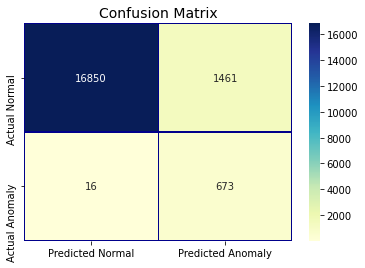

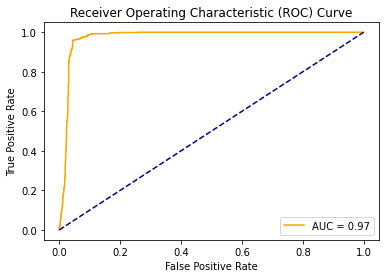

In [ ]:
#Adasyn
get_prediction(IForest(n_estimators = 100, max_samples = 128, contamination = 0.04, random_state= 42), 
                train_X_ada, test_X, train_y_ada, test_y, 'normal', 'IForest', scaler = StandardScaler(), Oversample = True)

On Training Data:
IForest ROC:0.5562, precision @ rank n:0.5777

On Test Data:
IForest ROC:0.3484, precision @ rank n:0.0987

 IForest  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.97      0.99      0.98     18311
     Anomaly       0.26      0.09      0.14       689

    accuracy                           0.96     19000
   macro avg       0.61      0.54      0.56     19000
weighted avg       0.94      0.96      0.95     19000


 IForest  Confusion Matrix: 
 [[18126   185]
 [  624    65]]

 IForest Matthews Correlation Coefficient 0.13819579576587213

 IForest f1-score 0.13844515441959532


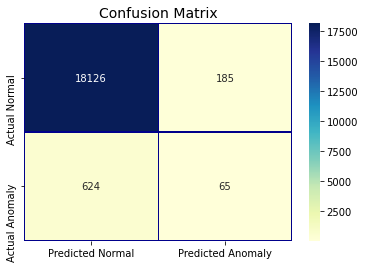

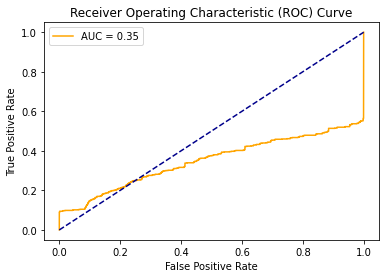

In [ ]:
#Smote
get_prediction(IForest(n_estimators = 100, max_samples = 128, contamination = 0.04, random_state= 42), 
                train_X_smote, test_X, train_y_smote, test_y, 'normal', 'IForest', scaler = StandardScaler(), Oversample = True)

Standardized & Not-Oversampled

On Training Data:
IForest ROC:0.941, precision @ rank n:0.2713

On Test Data:
IForest ROC:0.9516, precision @ rank n:0.3251

 IForest  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.97      0.97      0.97     18311
     Anomaly       0.31      0.34      0.32       689

    accuracy                           0.95     19000
   macro avg       0.64      0.65      0.65     19000
weighted avg       0.95      0.95      0.95     19000


 IForest  Confusion Matrix: 
 [[17795   516]
 [  457   232]]

 IForest Matthews Correlation Coefficient 0.2966000575671496

 IForest f1-score 0.32289491997216424


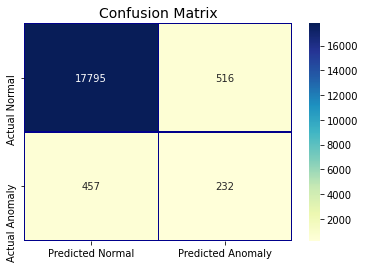

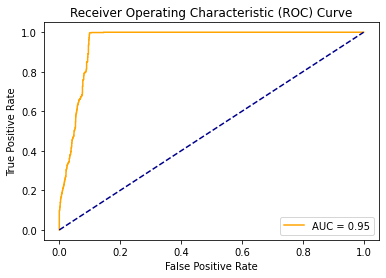

In [ ]:
get_prediction(IForest(n_estimators = 100, max_samples = 256, contamination = 0.04, random_state= 42), 
                train_X, test_X, train_y, test_y, 'normal', 'IForest', scaler = StandardScaler(), Oversample = False)

Not Standardized & Oversampled

On Training Data:
IForest ROC:0.9556, precision @ rank n:0.9076

On Test Data:
IForest ROC:0.9427, precision @ rank n:0.2424

 IForest  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.96      1.00      0.98     18311
     Anomaly       0.55      0.02      0.03       689

    accuracy                           0.96     19000
   macro avg       0.76      0.51      0.51     19000
weighted avg       0.95      0.96      0.95     19000


 IForest  Confusion Matrix: 
 [[18302     9]
 [  678    11]]

 IForest Matthews Correlation Coefficient 0.08920630775022795

 IForest f1-score 0.031029619181946407


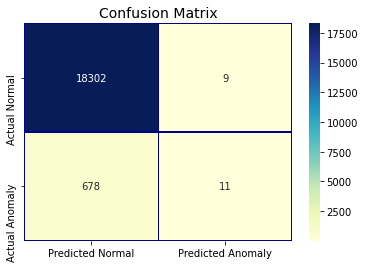

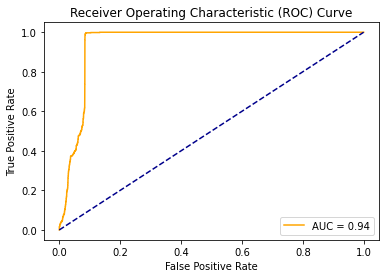

In [ ]:
#Adasyn
get_prediction(IForest(n_estimators = 100, max_samples = 256, contamination = 0.04, random_state= 42), 
                train_X_ada, test_X, train_y_ada, test_y, 'normal', 'IForest', scaler = None, Oversample = True)

On Training Data:
IForest ROC:0.5205, precision @ rank n:0.5579

On Test Data:
IForest ROC:0.5392, precision @ rank n:0.1045

 IForest  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.97      0.99      0.98     18311
     Anomaly       0.42      0.10      0.16       689

    accuracy                           0.96     19000
   macro avg       0.69      0.55      0.57     19000
weighted avg       0.95      0.96      0.95     19000


 IForest  Confusion Matrix: 
 [[18219    92]
 [  623    66]]

 IForest Matthews Correlation Coefficient 0.18685302837362033

 IForest f1-score 0.15584415584415584


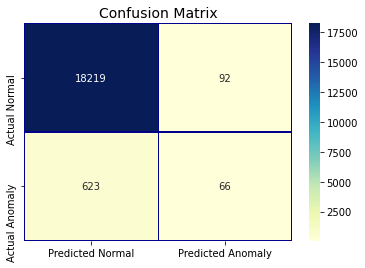

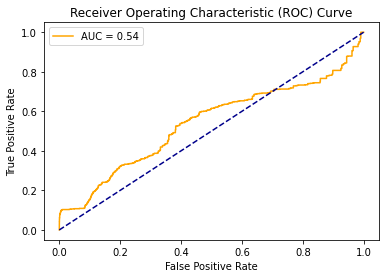

In [ ]:
#Smote
get_prediction(IForest(n_estimators = 100, max_samples = 256, contamination = 0.04, random_state= 42), 
                train_X_smote, test_X, train_y_smote, test_y, 'normal', 'IForest', scaler = None, Oversample = True)

Not Standardized & Not Oversampled

On Training Data:
IForest ROC:0.95, precision @ rank n:0.2561

On Test Data:
IForest ROC:0.9553, precision @ rank n:0.2903

 IForest  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.97      0.97      0.97     18311
     Anomaly       0.29      0.29      0.29       689

    accuracy                           0.95     19000
   macro avg       0.63      0.63      0.63     19000
weighted avg       0.95      0.95      0.95     19000


 IForest  Confusion Matrix: 
 [[17822   489]
 [  489   200]]

 IForest Matthews Correlation Coefficient 0.2635705028400212

 IForest f1-score 0.29027576197387517


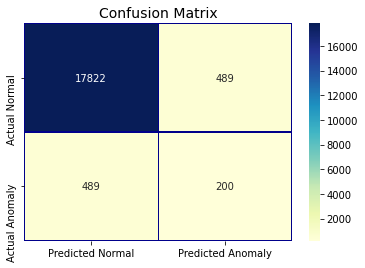

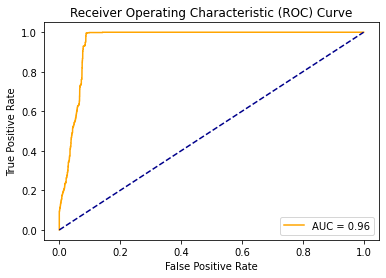

In [ ]:
#Smote
get_prediction(IForest(n_estimators = 100, max_samples = 128, contamination = 0.04, random_state= 42), 
                train_X, test_X, train_y, test_y, 'normal', 'IForest', scaler = None, Oversample = False)

#OCSVM

---



Standardized & Oversampled

On Training Data:
OCSVM ROC:0.7475, precision @ rank n:0.7239

On Test Data:
OCSVM ROC:0.9796, precision @ rank n:0.4194

 OCSVM  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.95      0.97     18311
     Anomaly       0.42      1.00      0.59       689

    accuracy                           0.95     19000
   macro avg       0.71      0.97      0.78     19000
weighted avg       0.98      0.95      0.96     19000


 OCSVM  Confusion Matrix: 
 [[17346   965]
 [    2   687]]

 OCSVM Matthews Correlation Coefficient 0.6265999640687077

 OCSVM f1-score 0.5869286629645452


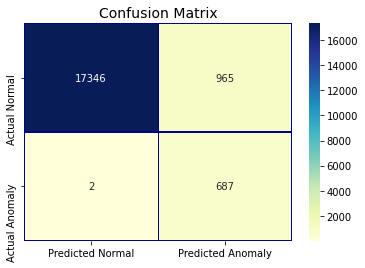

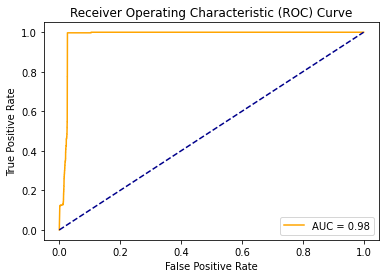

In [ ]:
#Adasyn
get_prediction(OCSVM(gamma = 'scale', contamination= 0.04, kernel = 'rbf'), 
               train_X_ada, test_X, train_y_ada, test_y, 'normal', 'OCSVM', scaler=StandardScaler(), Oversample = True)

On Training Data:
OCSVM ROC:0.562, precision @ rank n:0.49

On Test Data:
OCSVM ROC:0.9621, precision @ rank n:0.2612

 OCSVM  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.97      0.98      0.98     18311
     Anomaly       0.24      0.13      0.17       689

    accuracy                           0.95     19000
   macro avg       0.60      0.56      0.57     19000
weighted avg       0.94      0.95      0.95     19000


 OCSVM  Confusion Matrix: 
 [[18017   294]
 [  596    93]]

 OCSVM Matthews Correlation Coefficient 0.15738570920288275

 OCSVM f1-score 0.17286245353159854


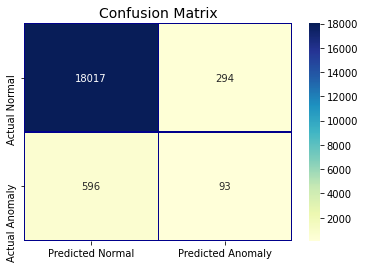

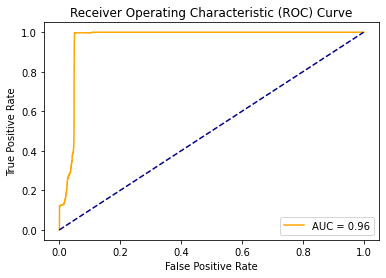

In [ ]:
#Smote
get_prediction(OCSVM(gamma = 'scale', contamination= 0.04, kernel = 'rbf'), 
               train_X_smote, test_X, train_y_smote, test_y, 'normal', 'OCSVM', scaler=StandardScaler(), Oversample = True)

Standardized & Not Oversampled

On Training Data:
OCSVM ROC:0.9725, precision @ rank n:0.3731

On Test Data:
OCSVM ROC:0.975, precision @ rank n:0.3788

 OCSVM  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.98      0.97      0.98     18311
     Anomaly       0.39      0.52      0.44       689

    accuracy                           0.95     19000
   macro avg       0.69      0.74      0.71     19000
weighted avg       0.96      0.95      0.96     19000


 OCSVM  Confusion Matrix: 
 [[17754   557]
 [  334   355]]

 OCSVM Matthews Correlation Coefficient 0.4239884405871361

 OCSVM f1-score 0.44347282948157407


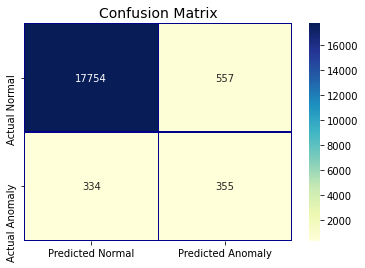

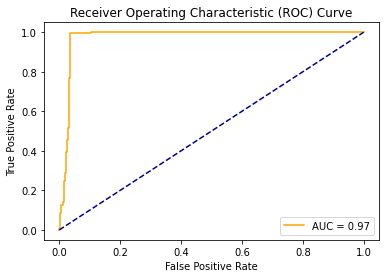

In [ ]:
get_prediction(OCSVM(gamma = 'scale', contamination= 0.04, kernel = 'rbf'), 
               train_X, test_X, train_y, test_y, 'normal', 'OCSVM', scaler=StandardScaler(), Oversample = False)

#LOF

---



Standardized & Oversampled

On Training Data:
LOF ROC:0.4081, precision @ rank n:0.413

On Test Data:
LOF ROC:0.6848, precision @ rank n:0.4688

 LOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.98      0.96      0.97     18311
     Anomaly       0.34      0.51      0.40       689

    accuracy                           0.95     19000
   macro avg       0.66      0.73      0.69     19000
weighted avg       0.96      0.95      0.95     19000


 LOF  Confusion Matrix: 
 [[17624   687]
 [  340   349]]

 LOF Matthews Correlation Coefficient 0.3861614458024561

 LOF f1-score 0.4046376811594203


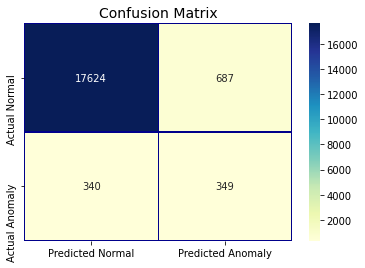

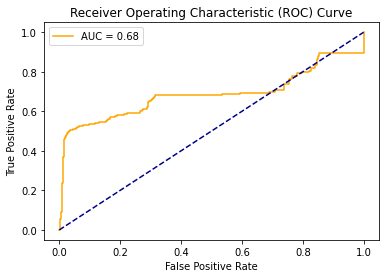

In [ ]:
#Adasyn
get_prediction(LOF(n_neighbors=500, contamination= 0.04, algorithm='auto'), 
               train_X_ada, test_X, train_y_ada, test_y, 'normal', 'LOF', scaler=StandardScaler(), Oversample = True)

On Training Data:
LOF ROC:0.4526, precision @ rank n:0.4215

On Test Data:
LOF ROC:0.452, precision @ rank n:0.1306

 LOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.97      0.99      0.98     18311
     Anomaly       0.26      0.08      0.12       689

    accuracy                           0.96     19000
   macro avg       0.61      0.53      0.55     19000
weighted avg       0.94      0.96      0.95     19000


 LOF  Confusion Matrix: 
 [[18156   155]
 [  635    54]]

 LOF Matthews Correlation Coefficient 0.12530094925470425

 LOF f1-score 0.12026726057906459


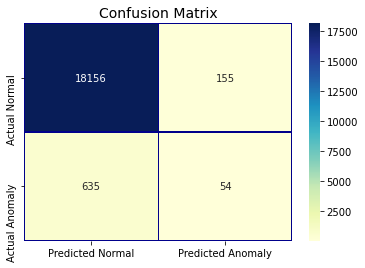

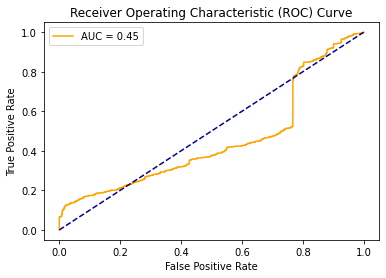

In [ ]:
#Smote
get_prediction(LOF(n_neighbors=500, contamination= 0.04, algorithm='auto'), 
               train_X_smote, test_X, train_y_smote, test_y, 'normal', 'LOF', scaler=StandardScaler(), Oversample = True)

Standardized & Not Oversampled

On Training Data:
LOF ROC:0.6776, precision @ rank n:0.4988

On Test Data:
LOF ROC:0.6844, precision @ rank n:0.4949

 LOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.98      0.98      0.98     18311
     Anomaly       0.48      0.50      0.49       689

    accuracy                           0.96     19000
   macro avg       0.73      0.74      0.73     19000
weighted avg       0.96      0.96      0.96     19000


 LOF  Confusion Matrix: 
 [[17935   376]
 [  346   343]]

 LOF Matthews Correlation Coefficient 0.4676086005117781

 LOF f1-score 0.4872159090909091


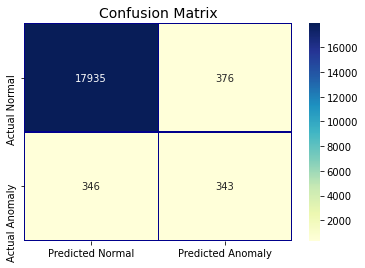

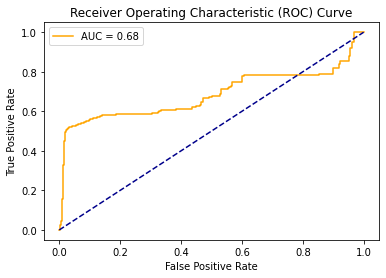

In [ ]:
get_prediction(LOF(n_neighbors=500, contamination= 0.04, algorithm='auto'), 
               train_X, test_X, train_y, test_y, 'normal', 'LOF', scaler=StandardScaler(), Oversample = False)

#CBLOF

---



Standardized & Oversampled

On Training Data:
CBLOF ROC:0.7274, precision @ rank n:0.6819

On Test Data:
CBLOF ROC:0.4955, precision @ rank n:0.0929

 CBLOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.97      0.96      0.97     18311
     Anomaly       0.09      0.09      0.09       689

    accuracy                           0.93     19000
   macro avg       0.53      0.53      0.53     19000
weighted avg       0.93      0.93      0.93     19000


 CBLOF  Confusion Matrix: 
 [[17659   652]
 [  624    65]]

 CBLOF Matthews Correlation Coefficient 0.05761845900532187

 CBLOF f1-score 0.09246088193456616


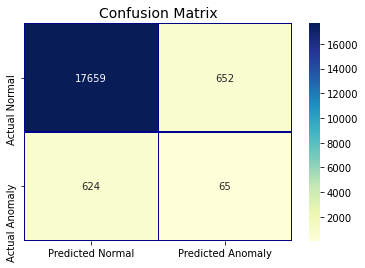

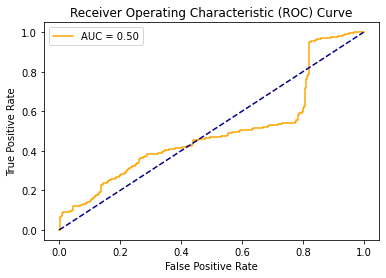

In [ ]:
#Adasyn
get_prediction(CBLOF(contamination= 0.04, n_clusters= 15, alpha= 0.9, beta= 15, random_state=42), 
               train_X_ada, test_X, train_y_ada, test_y, 'normal', 'CBLOF', scaler=StandardScaler(), Oversample = True)

On Training Data:
CBLOF ROC:0.3488, precision @ rank n:0.3635

On Test Data:
CBLOF ROC:0.3728, precision @ rank n:0.1263

 CBLOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.97      0.99      0.98     18311
     Anomaly       0.29      0.09      0.14       689

    accuracy                           0.96     19000
   macro avg       0.63      0.54      0.56     19000
weighted avg       0.94      0.96      0.95     19000


 CBLOF  Confusion Matrix: 
 [[18165   146]
 [  628    61]]

 CBLOF Matthews Correlation Coefficient 0.14507946880717978

 CBLOF f1-score 0.1361607142857143


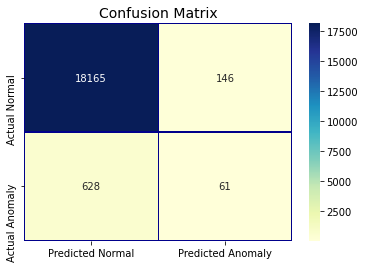

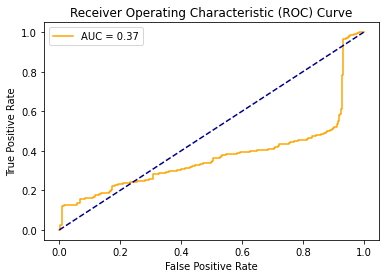

In [ ]:
#Smote
get_prediction(CBLOF(contamination= 0.04, n_clusters= 15, alpha= 0.9, beta= 15, random_state=42), 
               train_X_smote, test_X, train_y_smote, test_y, 'normal', 'CBLOF', scaler=StandardScaler(), Oversample = True)

Standardized & Not Oversampled

On Training Data:
CBLOF ROC:0.9912, precision @ rank n:0.7456

On Test Data:
CBLOF ROC:0.991, precision @ rank n:0.7282

 CBLOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      0.99      0.99     18311
     Anomaly       0.75      0.81      0.78       689

    accuracy                           0.98     19000
   macro avg       0.87      0.90      0.88     19000
weighted avg       0.98      0.98      0.98     19000


 CBLOF  Confusion Matrix: 
 [[18124   187]
 [  131   558]]

 CBLOF Matthews Correlation Coefficient 0.7701942915128343

 CBLOF f1-score 0.7782426778242678


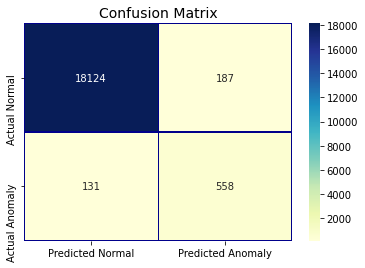

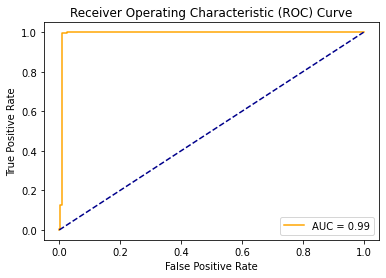

In [ ]:
get_prediction(CBLOF(contamination= 0.04, n_clusters= 20, alpha= 0.9, beta= 15, random_state=42), 
               train_X, test_X, train_y, test_y, 'normal', 'CBLOF', scaler=StandardScaler(), Oversample = False)

#KNN

---



Standardized & Oversampled

On Training Data:
KNN ROC:0.6216, precision @ rank n:0.5924

On Test Data:
KNN ROC:0.5982, precision @ rank n:0.2308

 KNN  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.97      0.97      0.97     18311
     Anomaly       0.22      0.25      0.23       689

    accuracy                           0.94     19000
   macro avg       0.60      0.61      0.60     19000
weighted avg       0.94      0.94      0.94     19000


 KNN  Confusion Matrix: 
 [[17722   589]
 [  520   169]]

 KNN Matthews Correlation Coefficient 0.20356917394473

 KNN f1-score 0.23358673116793366


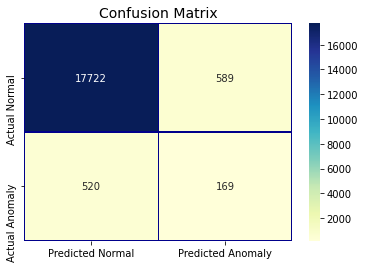

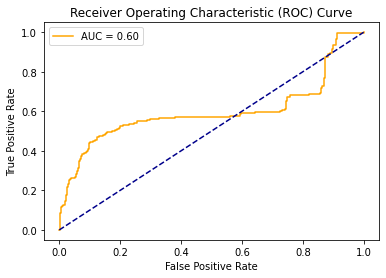

In [ ]:
#Adasyn
get_prediction(KNN(n_neighbors= 500, method= 'largest', algorithm='auto',contamination= 0.04), 
               train_X_ada, test_X, train_y_ada, test_y, 'normal', 'KNN', scaler=StandardScaler(), Oversample = True)

On Training Data:
KNN ROC:0.2516, precision @ rank n:0.2917

On Test Data:
KNN ROC:0.2724, precision @ rank n:0.0464

 KNN  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.96      0.96      0.96     18311
     Anomaly       0.05      0.05      0.05       689

    accuracy                           0.93     19000
   macro avg       0.51      0.51      0.51     19000
weighted avg       0.93      0.93      0.93     19000


 KNN  Confusion Matrix: 
 [[17647   664]
 [  657    32]]

 KNN Matthews Correlation Coefficient 0.010132372061344206

 KNN f1-score 0.046209386281588445


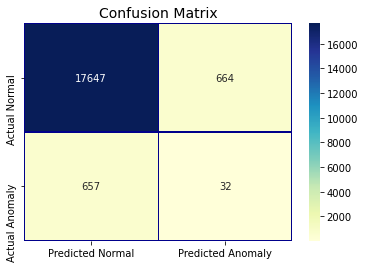

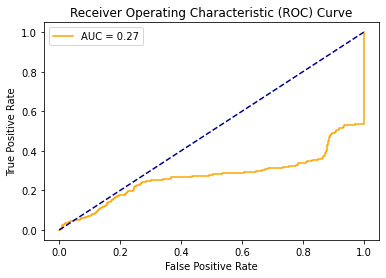

In [ ]:
#Smote
get_prediction(KNN(n_neighbors= 500, method= 'largest', algorithm='auto',contamination= 0.04), 
               train_X_smote, test_X, train_y_smote, test_y, 'normal', 'KNN', scaler=StandardScaler(), Oversample = True)

Standardized & Not Oversampled

On Training Data:
KNN ROC:0.5957, precision @ rank n:0.2526

On Test Data:
KNN ROC:0.6054, precision @ rank n:0.2612

 KNN  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.97      0.97      0.97     18311
     Anomaly       0.25      0.26      0.25       689

    accuracy                           0.94     19000
   macro avg       0.61      0.62      0.61     19000
weighted avg       0.95      0.94      0.95     19000


 KNN  Confusion Matrix: 
 [[17760   551]
 [  508   181]]

 KNN Matthews Correlation Coefficient 0.22593833521065845

 KNN f1-score 0.2547501759324419


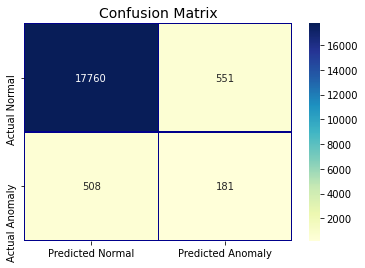

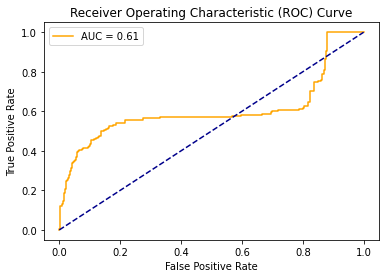

In [ ]:
get_prediction(KNN(n_neighbors= 500, method= 'largest', algorithm='auto',contamination= 0.04), 
               train_X, test_X, train_y, test_y, 'normal', 'KNN', scaler=StandardScaler(), Oversample = False)

#Isotree-IsolationForest


---





Standardized & Oversampled


 IForest  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.92      0.95     18311
           1       0.28      0.84      0.42       689

    accuracy                           0.91     19000
   macro avg       0.63      0.88      0.68     19000
weighted avg       0.97      0.91      0.93     19000


 IForest  Confusion Matrix: 
 [[16796  1515]
 [  110   579]]

 IForest Matthews Correlation Coefficient 0.45227569038349563

 IForest f1-score 0.41609773625583907


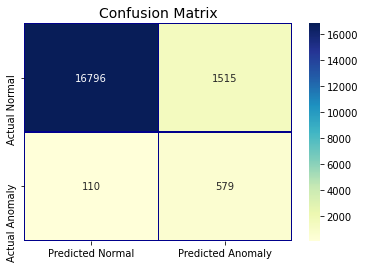

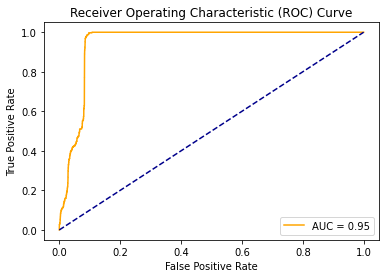

In [ ]:
#Adasyn
get_prediction_iso(IsolationForest(sample_size = 128, ndim=1, ntrees=100, penalize_range=False, missing_action = "fail"), 
                   train_X_ada, test_X, train_y_ada, test_y, 'normal', 'IForest', scaler=StandardScaler(), Oversample = True)


 IForest  Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.91      0.94     18311
           1       0.05      0.13      0.08       689

    accuracy                           0.88     19000
   macro avg       0.51      0.52      0.51     19000
weighted avg       0.93      0.88      0.91     19000


 IForest  Confusion Matrix: 
 [[16687  1624]
 [  598    91]]

 IForest Matthews Correlation Coefficient 0.028303792233404238

 IForest f1-score 0.07570715474209651


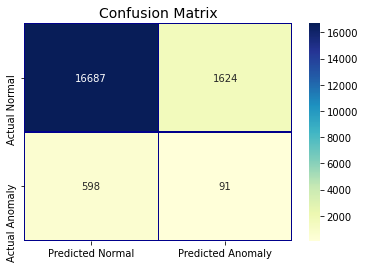

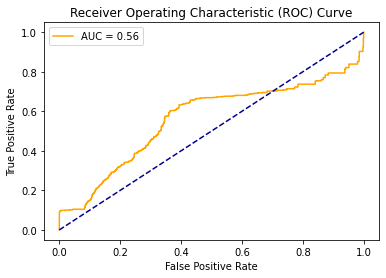

In [ ]:
#Smote
get_prediction_iso(IsolationForest(sample_size = 128, ndim=1, ntrees=100, penalize_range=False, missing_action = "fail"), 
                   train_X_smote, test_X, train_y_smote, test_y, 'normal', 'IForest', scaler=StandardScaler(), Oversample = True)

Standardized & Not Oversampled


 IForest  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95     18311
           1       0.28      1.00      0.44       689

    accuracy                           0.91     19000
   macro avg       0.64      0.95      0.69     19000
weighted avg       0.97      0.91      0.93     19000


 IForest  Confusion Matrix: 
 [[16561  1750]
 [    1   688]]

 IForest Matthews Correlation Coefficient 0.5047419531280657

 IForest f1-score 0.44003837543971863


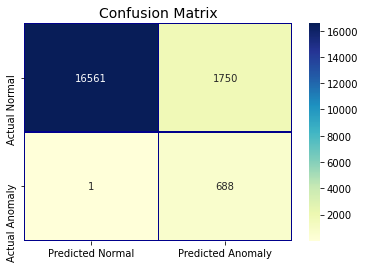

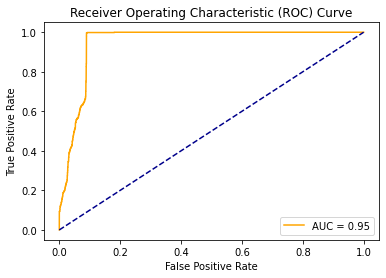

In [ ]:
get_prediction_iso(IsolationForest(sample_size = 128, ndim=1, ntrees=100, penalize_range=False, missing_action = "fail"), 
                   train_X, test_X, train_y, test_y, 'normal', 'IForest', scaler=StandardScaler(), Oversample = False)

Not Standardized & Oversampled


 IForest  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.92      0.95     18311
           1       0.28      0.84      0.42       689

    accuracy                           0.91     19000
   macro avg       0.63      0.88      0.68     19000
weighted avg       0.97      0.91      0.93     19000


 IForest  Confusion Matrix: 
 [[16796  1515]
 [  110   579]]

 IForest Matthews Correlation Coefficient 0.45227569038349563

 IForest f1-score 0.41609773625583907


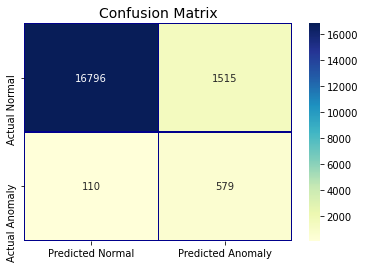

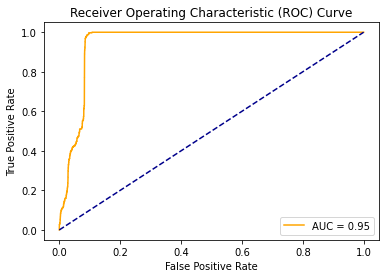

In [ ]:
#Adasyn
get_prediction_iso(IsolationForest(sample_size = 128, ndim=1, ntrees=100, penalize_range=False, missing_action = "fail"), 
                   train_X_ada, test_X, train_y_ada, test_y, 'normal', 'IForest', scaler=None, Oversample = True)


 IForest  Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.91      0.94     18311
           1       0.05      0.13      0.08       689

    accuracy                           0.88     19000
   macro avg       0.51      0.52      0.51     19000
weighted avg       0.93      0.88      0.91     19000


 IForest  Confusion Matrix: 
 [[16687  1624]
 [  598    91]]

 IForest Matthews Correlation Coefficient 0.028303792233404238

 IForest f1-score 0.07570715474209651


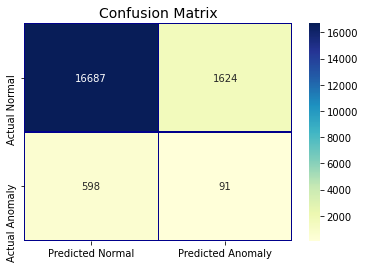

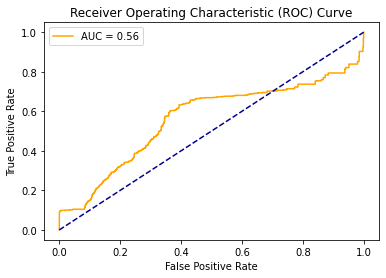

In [ ]:
#Smote
get_prediction_iso(IsolationForest(sample_size = 128, ndim=1, ntrees=100, penalize_range=False, missing_action = "fail"), 
                   train_X_smote, test_X, train_y_smote, test_y, 'normal', 'IForest', scaler=None, Oversample = True)

Not Standardized & Not Oversampled


 IForest  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95     18311
           1       0.28      1.00      0.44       689

    accuracy                           0.91     19000
   macro avg       0.64      0.95      0.69     19000
weighted avg       0.97      0.91      0.93     19000


 IForest  Confusion Matrix: 
 [[16561  1750]
 [    1   688]]

 IForest Matthews Correlation Coefficient 0.5047419531280657

 IForest f1-score 0.44003837543971863


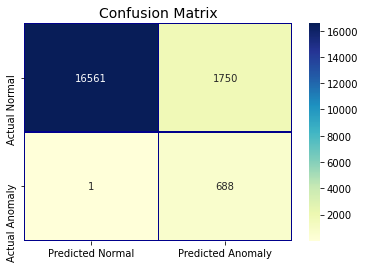

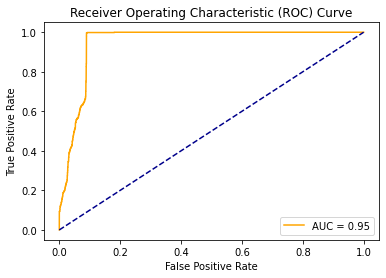

In [ ]:
#Does not work well on oversampled data
get_prediction_iso(IsolationForest(sample_size = 128, ndim=1, ntrees=100, penalize_range=False, missing_action = "fail"), 
                   train_X, test_X, train_y, test_y, 'normal', 'IForest', scaler=None, Oversample = False)

#Isotree-SciForest

---



Standardized & Oversampled


 SciForest  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.91      0.95     18311
           1       0.28      0.91      0.43       689

    accuracy                           0.91     19000
   macro avg       0.64      0.91      0.69     19000
weighted avg       0.97      0.91      0.93     19000


 SciForest  Confusion Matrix: 
 [[16697  1614]
 [   62   627]]

 SciForest Matthews Correlation Coefficient 0.47634784097879185

 SciForest f1-score 0.4279863481228669


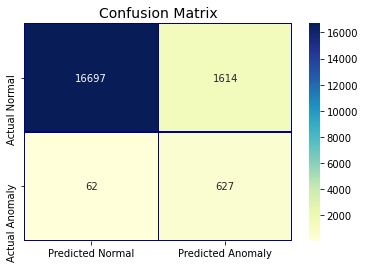

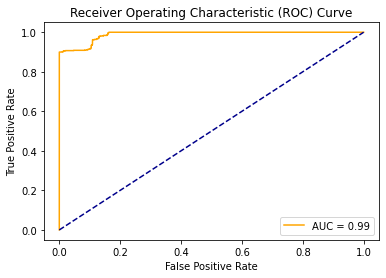

In [ ]:
#Adasyn
get_prediction_iso(IsolationForest(sample_size = 128, ndim=2, ntrees=100, ntry=10, penalize_range=True, prob_pick_avg_gain=1, missing_action = "fail"), 
                   train_X_ada, test_X, train_y_ada, test_y, 'normal', 'SciForest', scaler=StandardScaler(), Oversample = True)


 SciForest  Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.91      0.94     18311
           1       0.05      0.13      0.07       689

    accuracy                           0.88     19000
   macro avg       0.51      0.52      0.50     19000
weighted avg       0.93      0.88      0.90     19000


 SciForest  Confusion Matrix: 
 [[16620  1691]
 [  600    89]]

 SciForest Matthews Correlation Coefficient 0.023624808272079675

 SciForest f1-score 0.07209396516808424


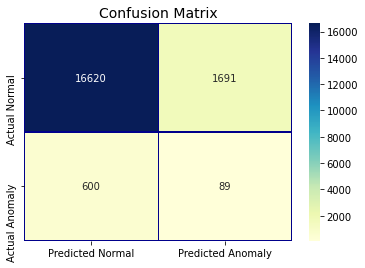

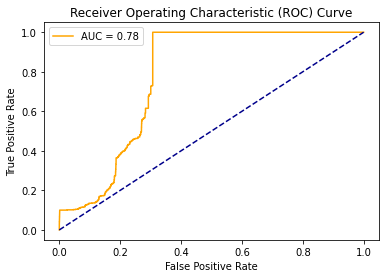

In [ ]:
#Smote
get_prediction_iso(IsolationForest(sample_size = 128, ndim=2, ntrees=100, ntry=10, penalize_range=True, prob_pick_avg_gain=1, missing_action = "fail"), 
                   train_X_smote, test_X, train_y_smote, test_y, 'normal', 'SciForest', scaler=StandardScaler(), Oversample = True)

Standardized & Not Oversampled


 SciForest  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.94      0.97     18311
           1       0.38      1.00      0.55       689

    accuracy                           0.94     19000
   macro avg       0.69      0.97      0.76     19000
weighted avg       0.98      0.94      0.95     19000


 SciForest  Confusion Matrix: 
 [[17198  1113]
 [    1   688]]

 SciForest Matthews Correlation Coefficient 0.5984824671117398

 SciForest f1-score 0.5526104417670683


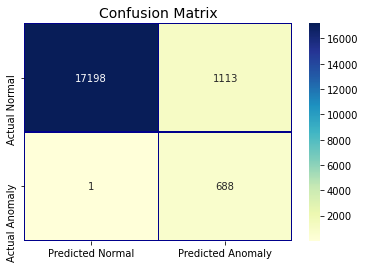

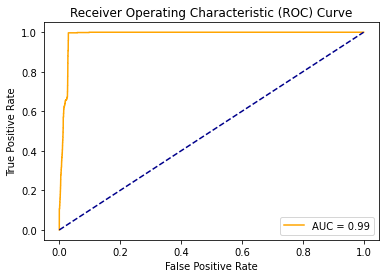

In [ ]:
#Adasyn
get_prediction_iso(IsolationForest(sample_size = 256, ndim=2, ntrees=100, ntry=10, penalize_range=True, prob_pick_avg_gain=1, missing_action = "fail"), 
                   train_X, test_X, train_y, test_y, 'normal', 'SciForest', scaler=StandardScaler(), Oversample = False)

Not Standardized & Oversampled


 SciForest  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.92      0.96     18311
           1       0.30      0.91      0.45       689

    accuracy                           0.92     19000
   macro avg       0.65      0.91      0.71     19000
weighted avg       0.97      0.92      0.94     19000


 SciForest  Confusion Matrix: 
 [[16870  1441]
 [   63   626]]

 SciForest Matthews Correlation Coefficient 0.49823827311333774

 SciForest f1-score 0.45428156748911463


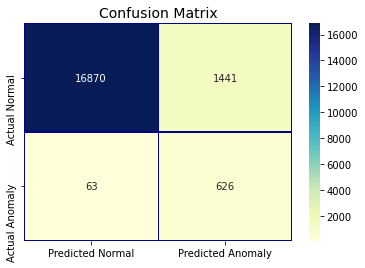

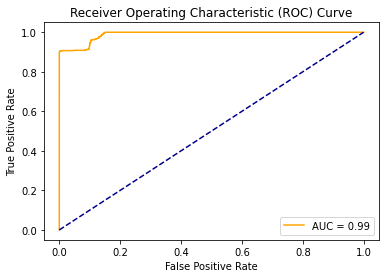

In [ ]:
#Adasyn
get_prediction_iso(IsolationForest(sample_size = 256, ndim=2, ntrees=100, ntry=10, penalize_range=True, prob_pick_avg_gain=1, missing_action = "fail"), 
                   train_X_ada, test_X, train_y_ada, test_y, 'normal', 'SciForest', scaler=None, Oversample = True)


 SciForest  Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.91      0.94     18311
           1       0.05      0.13      0.08       689

    accuracy                           0.88     19000
   macro avg       0.51      0.52      0.51     19000
weighted avg       0.93      0.88      0.91     19000


 SciForest  Confusion Matrix: 
 [[16717  1594]
 [  600    89]]

 SciForest Matthews Correlation Coefficient 0.027713293782722772

 SciForest f1-score 0.07504215851602025


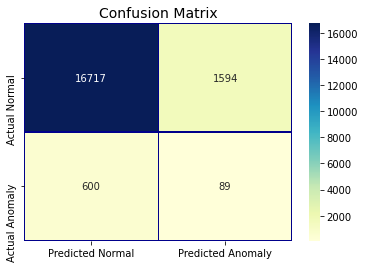

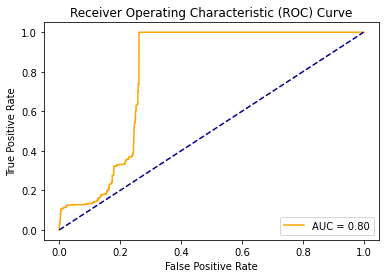

In [ ]:
##Smote
get_prediction_iso(IsolationForest(sample_size = 256, ndim=2, ntrees=100, ntry=10, penalize_range=True, prob_pick_avg_gain=1, missing_action = "fail"), 
                   train_X_smote, test_X, train_y_smote, test_y, 'normal', 'SciForest', scaler=None, Oversample = True)

Not Standardized & Not Oversampled


 SciForest  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.94      0.97     18311
           1       0.38      1.00      0.55       689

    accuracy                           0.94     19000
   macro avg       0.69      0.97      0.76     19000
weighted avg       0.98      0.94      0.95     19000


 SciForest  Confusion Matrix: 
 [[17198  1113]
 [    1   688]]

 SciForest Matthews Correlation Coefficient 0.5984824671117398

 SciForest f1-score 0.5526104417670683


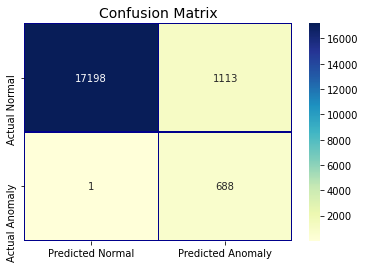

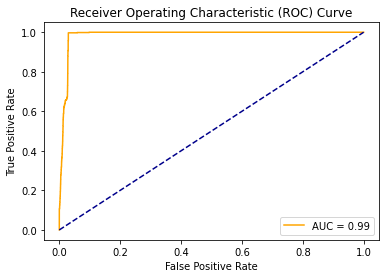

In [ ]:
get_prediction_iso(IsolationForest(sample_size = 256, ndim=2, ntrees=100, ntry=10, penalize_range=True, prob_pick_avg_gain=1, missing_action = "fail"), 
                   train_X, test_X, train_y, test_y, 'normal', 'SciForest', scaler=None, Oversample = False)